### On the unit commitment problem
This notebook contains the dynamic programming solution to a 2-unit commitment problem.

The notation, state transition dynamics and cost, follow that in:

``Lauer, G.S., Sandell, N.R., Bertsekas, D.P. and Posbergh, T.A., 1982. Solution of large-scale optimal unit commitment problems. IEEE Transactions on Power Apparatus and Systems, (1), pp.79-86.''

In [1]:
# Loading used packages
using Plots, LaTeXStrings

We first define the state transition dynamics, as defined in Fig. 1 in the above reference.

In [2]:
function state_transition(state::Int, action::Int)
    stateVec = zeros(Int, 11,)
    stateVec[state] = 1
    # We define the state transition matrix P
    P = zeros(Int, 11, 11)
    if action == 0
    P[[
    CartesianIndex(1,4), 
    CartesianIndex(2,1),    CartesianIndex(3,2),    CartesianIndex(4,5),    
    CartesianIndex(5,6),    CartesianIndex(6,7),    CartesianIndex(7,8),
    CartesianIndex(8,9),    CartesianIndex(9,10),
    CartesianIndex(10,11),    CartesianIndex(11,11)]] .= 1

    elseif action >= 1
    P[[
    CartesianIndex(1,1),    CartesianIndex(2,1),    CartesianIndex(3,2),
    CartesianIndex(4,5),    CartesianIndex(5,6),    CartesianIndex(6,7),
    CartesianIndex(7,3),    CartesianIndex(8,3),    CartesianIndex(9,3),
    CartesianIndex(10,3),    CartesianIndex(11,3)]] .= 1
    end
    return findfirst(==(1), P' * stateVec)

end

state_transition (generic function with 1 method)

We have 11 states according to the figure, the states {1,2,3} correspond to the up states, and {4,...,11} are the down states. The states are ordered top to bottom as in Fig. 1.

The control action takes the value 0 when shutting down, and the values {1,...,GridSize} when starting up.

The reason of multiple values of action for the starting up is to determine the output power of the unit while running. The value 1 corresponds to the unit being running but with the lowest output power $\underline g_i$ (g_min in code) and GridSize to the maximum output $\bar g_i$ (g_max in code). G_grid is the number of grid points when we discretize the output power $g_i^t \in [\underline g_i,\bar g_i]$.

In [3]:
GridSize = 20
g_min = 1
g_max = 2
OutPowerGrid = [0; range(g_min, g_max, GridSize)];

Notice that in the state_transition function, action that is in {1,...,GridSize} resulted in the same transition (u=1 in the paper). This is because the 11 states are only affected by the {on, off} decision, but not affected by the output power $g_i^t$ when the unit $i$ is on. Therefore, since the output power has no dynamics (as long as the unit is on), we regard it as a constrained input rather than a state.

The function below describes the set of feasible actions $A$ for each state $s$.

In [4]:
function feasible_action_set(s::Int)
    if s in [1,7,8,9,10,11]
        A = 0:GridSize
    elseif s in [2,3]
        A = 1:GridSize
    elseif s in [4,5,6]
        A = 0
    end
    return A
end;

That is, the feasible action set $A(s)$ is a function of the state $s$:
- the feasible action set can only contain $0$ for states $\{4,5,6\}$ (minimum down time not achieved yet; the unit cannot be truned up)
- the feasible action set can be all possible actions $\{0,...,GridSize\}$ for states $\{1,7,8,...,11\}$.
- the feasibile action set is $\{1,...,GridSize\}$ for states 2 and 3 (minimum up time not achieved yet).

Now suppose that we have 2 units that are to be used (either one or both) in the generation of power to meet an expected value $D^t$ at time $t$. That is, if the power generated by each unit is $g_i^t$ for $i=1,2$, then we need $\sum_{i=1}^2 g_i^t \geq D^t$, for all $t\in \{1,...,T\}$, $T$ is the horizon length.

In [5]:
T = 24
Dᵗ = rand(T,) .+ 1.0;

We solve this problem by a solving a dynamic programming (DP) problem, in particular, we use value iteration (VI). We use the following to store the results (value and policy).

In [6]:
val = zeros(11, 11, T+1)
π = zeros(Int, 11, 11, T, 2);

For this DP, 
- the states are $s_1,s_2$ corresponding to each unit and each taking value in $\{1,...,11\}$.
- the input constraints are defined by feasible_action_set function above, and by the output power requirement $\sum_{i=1}^2 g_i^t \geq D^t$, for all $t\in \{1,...,T\}$

Remember, each action in $\{1,...,GridSize\}$ corresponds to a different level of output power $g_i^t$. Hence, the above inequality can be seen as an input constraint.

The running cost of the input, or in other words, the fuel cost for each output level $g_i^t$ (hence for each action), is defined as follows:

In [7]:
function fuel_cost(gᵢᵗ)
    return gᵢᵗ
end

fuel_cost (generic function with 1 method)

Now we solve this finite-horizon DP backward in time, from $T$ backward to time $1$. The below code applies the following recursion
$$ V(s_1,s_2) = \min_{a_1\in A(s_1),\,a_2 \in A(s_2),\,\sum_{i=1}^2 g_i^t(a_i) \geq D^t} \{ \text{fuel cost of}(g_1^t(a_1),g_1^t(a_2)) + V(P(a_1)^Ts_1,P(a_2)^Ts_2) \},$$
where $V(s_1,s_2)$ is the value of being at state $(s_1,s_2)$, for the two units respectively, and the constraint sets

In [8]:
function apply_DP(T::Int, s₁::Int, s₂::Int)
val = zeros(11, 11, T+1)
π = zeros(Int, 11, 11, T, 2);
for t in T:-1:1
   
    for s₁ in 1:11
    for s₂ in 1:11
        # iterating over the state-space
        Qₐ = 10 ^ 8 * ones(GridSize + 1, GridSize + 1) # the cost of each action
        # each action is 10^8 expensive unless proven otherwise
        A = feasible_action_set.([s₁,s₂]) # vector of feasible action sets
        for a₁ in A[1]
        for a₂ in A[2]
            # iterating over each possible action
            s₁⁺ = state_transition(s₁, a₁)
            s₂⁺ = state_transition(s₂, a₂)
            g₁ᵗ, g₂ᵗ = OutPowerGrid[a₁ + 1], OutPowerGrid[a₂ + 1] # matching action to corresponding gᵢᵗ
            # the action value function:
            Qₐ[a₁ + 1, a₂ + 1] = 1/T * (fuel_cost(g₁ᵗ) + fuel_cost(g₂ᵗ)) + val[s₁⁺, s₂⁺, t + 1]
            if g₁ᵗ + g₂ᵗ < Dᵗ[t]
                Qₐ[a₁ + 1, a₂ + 1] = 10 ^ 8
            end
        end
        end
        val[s₁, s₂, t] = minimum(Qₐ)
        π[s₁, s₂, t, :] = [argmin(Qₐ)[1] - 1, argmin(Qₐ)[2] - 1]
        if val[s₁, s₂, t] >= 10 ^ 8
            π[s₁, s₂, t, :] = [-1, -1] # policy is set to -1, which is not a valid action
            # this is a flag that there is no feasible action at that state and that time
        end
    end
    end
end
return val, π
end;

We apply the above function now

In [18]:
T = 24
Dᵗ = rand(T,) .+ 1.0
s₁ = rand(1:3)
s₂ = rand(1:3)
val, π = apply_DP(T, s₁, s₂);

Now we use the feedback policy $\pi$ in simulation and plot the achieved power versus the expected one.

In [19]:
function simulate_example(s₁, s₂)
    S_rec = zeros(Int, 2, 24)
    cost_rec = zeros(24,)
    for t in 1:24
        S_rec[:,t] = [s₁; s₂]
        actions = π[s₁, s₂, t, :]
        s₁⁺ = state_transition(s₁, actions[1])
        s₂⁺ = state_transition(s₂, actions[2])
        s₁ = s₁⁺
        s₂ = s₂⁺
        g₁ᵗ, g₂ᵗ = OutPowerGrid[actions[1] + 1], OutPowerGrid[actions[2] + 1]
        cost_rec[t] = g₁ᵗ + g₂ᵗ
    end
    return S_rec, cost_rec
end;

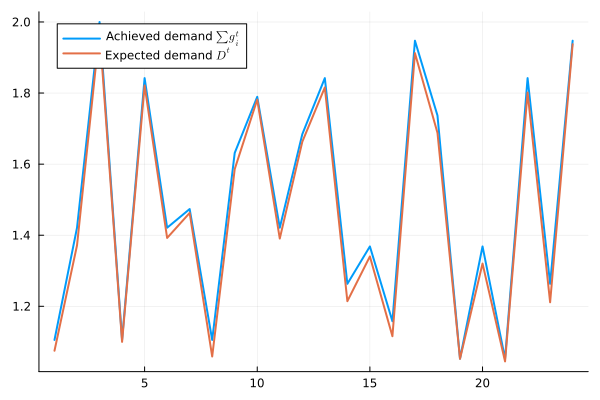

In [21]:
S_rec, cost_rec = simulate_example(s₁, s₂);
costPlot = plot(cost_rec, lw=2, label = L"Achieved demand $\sum g_i^t$")
costPlot = plot!(Dᵗ, lw=2, label = L"Expected demand $D^t$")
plot(costPlot)
#savefig("achievedVsexpected")

In [22]:
s₁ = rand(1:3)
s₂ = rand(1:3)
val0 = zeros(11, 11)
error = []
for T in 2:12
    Dᵗ = 1.5 .* ones(T,)
    val, π = apply_DP(T, s₁, s₂);
    push!(error, sum((val[:,:,1]-val0) .^ 2))
    val0 = val[:,:,1]
end

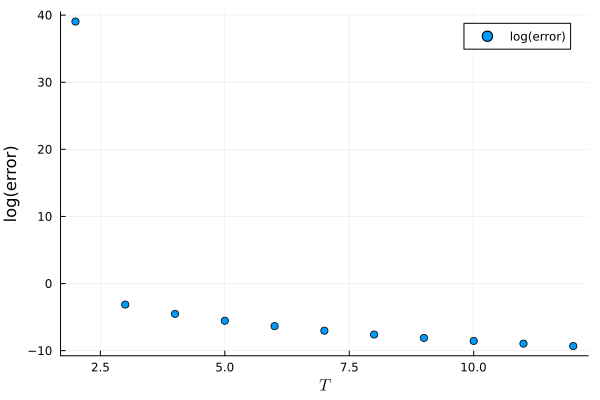

In [24]:
scatter(2:12, log.(error), xlabel =L"T", ylabel = "log(error)", label="log(error)")
#savefig("error")